# Wave Finder Overview
This will be part of a data pipeline into a DL ensemble.

We will identify crypto metrics used in trading.

The metrics are as follows and this lab may not include them all, but its good to see what we must identify.

1. Wave finder
2. Stochastic RSI
3. Fibonacci Levels
4. volume
5. News events
6. All Time frames
7. Fundamental data (network, mining, coins, etc.)

## DL Model
Once we have gathered the information for our dl model we will need to impliment it into our ensemble.
The wave finder will be used as a fibonacci trace for projections
Our target will either be price or percent change, perhaps we can even make our target more open to interpretation by simply making it a multi classification with 3 outputs. Buy, sell, do nothing. It's possible we can use binary classification with a softmax activation on the output to achieve this.
## Preprocessing
This will take up most of our time. Figuring out how to vectorize the timeseries information. We want our ensemble to include all time perspectives for maximum accuracy. 1m to 1M. This way all moves will be considered. Perhaps we can see each network output from each timeframe into a final network?

# Get the data
In order to find waves in any asset we need the OHLC data and a MACD algorithm. We then need to find the zero line crossings and segment each crossing as a wave. From there we find the price high and price low within that wave segment and the macd high/low. We can then further look for divergence between waves and identify another added feature. 

In [1]:
import pandas as pd
import requests
import datetime

# Taken from https://medium.com/@galea/cryptocompare-api-quick-start-guide-ca4430a484d4

def daily_price_historical(symbol, comparison_symbol, all_data=True, limit=2000, aggregate=1, exchange=''):
    """ Gets the historical daily prices"""
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    df = df.set_index('timestamp')
    df = df.drop(['time'], axis=1)

    return df

def hourly_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    """Gets the historical hourly prices"""
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    df = df.set_index('timestamp')
    df = df.drop(['time'], axis=1)
    
    return df

def minute_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    """ Gets the historical prices by minute"""
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    df = df.set_index('timestamp')
    df = df.drop(['time'], axis=1)
    
    return df

def price(symbol, comparison_symbols=['USD'], exchange=''):
    """ 
    Gets the live coin price 
    price('BTC', ['USD, ETH'], exchange='Coinbase')
    """
    url = 'https://min-api.cryptocompare.com/data/price?fsym={}&tsyms={}'\
            .format(symbol.upper(), ','.join(comparison_symbols).upper())
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()
    
    return data

In [2]:
exchange = 'BITFINEX'
df = daily_price_historical('BTC', 'USD', all_data=True, exchange=exchange)

In [ ]:
import requests

for i in range(255):
    print(i)
    try:
        data = requests.get('http://192.168.1.'+str(i+1))
        # print(i)
        status = data.status_code
        print(status)
    except:
        continue


# Find the MACD and RSI

In [5]:
from talib import MACD, RSI
slowperiod = 12
fastperiod = 26
signalperiod = 9 
overbought = 80
oversold = 20
macd, macdsignal, macdhist = MACD(df.close.values, slowperiod=slowperiod, fastperiod=fastperiod, signalperiod=signalperiod)
rsi = RSI(df.close)


In [32]:
# rsi = RSI(df.close)
# rsi
def rsi_strategy_001(dfsource, length=14, overbought=80, oversold=20):
    """ Simple RSI strategy:
        [1] Buy: RSI(t-1) < Oversold(t-1) and RSI(t) > Oversold(t)
        [-1]Sell: RSI(t-1) > Overbought(t-1) and RSI(t) < Overbought(t)
        [0] Hold: Otherwise
    """
    rsi = RSI(dfsource, length)
    results = []
    for i in range(len(rsi)):
        if rsi[i] == None:
            results.append(0)
            continue
            
        # Buy condition
        elif rsi[i-1] < oversold and rsi[i] > oversold:
            results.append(1)

        # Sell Condition
        elif rsi[i-1] > overbought and rsi[i] < overbought:
            results.append(-1)
            
        else:
            results.append(0)
    
    return results
results = rsi_strategy_001(df.close)
len(results)
df['results'] = results
df

,close,high,low,open,volumefrom,volumeto,macd,rsi,rsi_extreme,results
timestamp,,,,,,,,,,
2015-02-08 19:00:00,220.61,225.00,215.40,224.22,29625.03,6.493501e+06,NaN,NaN,NaN,0
2015-02-09 19:00:00,220.96,223.88,214.00,220.61,29268.95,6.402351e+06,NaN,NaN,NaN,0
2015-02-10 19:00:00,219.19,224.40,218.10,220.96,19289.28,4.268987e+06,NaN,NaN,NaN,0
2015-02-11 19:00:00,222.60,223.20,217.87,219.19,11190.65,2.468883e+06,NaN,NaN,NaN,0
2015-02-12 19:00:00,236.00,241.76,221.46,222.39,29079.11,6.806973e+06,NaN,NaN,NaN,0
2015-02-13 19:00:00,258.12,261.30,235.51,236.13,42984.94,1.073901e+07,NaN,NaN,NaN,0
2015-02-14 19:00:00,234.14,266.84,228.20,257.00,71361.28,1.738442e+07,NaN,NaN,NaN,0
2015-02-15 19:00:00,236.78,243.65,228.62,234.14,45750.85,1.079875e+07,NaN,NaN,NaN,0
2015-02-16 19:00:00,242.87,246.28,231.50,236.78,42669.08,1.022804e+07,NaN,NaN,NaN,0


In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
timeframe = '2010-08-01 20:00:00'
plt.plot(df.index,
        macd)
df['macd'] = macd
df['rsi'] = rsi
df[timeframe:]

,close,high,low,open,volumefrom,volumeto,macd,rsi
timestamp,,,,,,,,
2015-02-08 19:00:00,220.61,225.00,215.40,224.22,29625.03,6.493501e+06,NaN,NaN
2015-02-09 19:00:00,220.96,223.88,214.00,220.61,29268.95,6.402351e+06,NaN,NaN
2015-02-10 19:00:00,219.19,224.40,218.10,220.96,19289.28,4.268987e+06,NaN,NaN
2015-02-11 19:00:00,222.60,223.20,217.87,219.19,11190.65,2.468883e+06,NaN,NaN
2015-02-12 19:00:00,236.00,241.76,221.46,222.39,29079.11,6.806973e+06,NaN,NaN
2015-02-13 19:00:00,258.12,261.30,235.51,236.13,42984.94,1.073901e+07,NaN,NaN
2015-02-14 19:00:00,234.14,266.84,228.20,257.00,71361.28,1.738442e+07,NaN,NaN
2015-02-15 19:00:00,236.78,243.65,228.62,234.14,45750.85,1.079875e+07,NaN,NaN
2015-02-16 19:00:00,242.87,246.28,231.50,236.78,42669.08,1.022804e+07,NaN,NaN


In [10]:
# Find Zero Crossings
import numpy
zero_crossings = numpy.where(numpy.diff(numpy.sign(macd)))[0]

In [11]:
# Find local Minima and local maxima
waves = []
waves_df = pd.DataFrame()
for i in range(len(zero_crossings)):
    # Get the current unfinished wave
    if len(zero_crossings)-1 == i:
        wave_range = df[zero_crossings[i]+1:]
    # Get all other complete waves
    else:
        wave_range = df[zero_crossings[i]+1:zero_crossings[i+1]+1]
        
    if len(wave_range) > 1:
        red_wave = wave_range.where(wave_range.macd < 0)
        green_wave = wave_range.where(wave_range.macd > 0)
        wave_start = wave_range.iloc[0]
        wave_end = wave_range.iloc[-1]
        macd_local_minimum = red_wave.macd.min()
        macd_local_maximum = green_wave.macd.max()
        price_local_minimum = red_wave.low.min()
        price_local_maximum = green_wave.high.max()
        data = pd.DataFrame({"Start": wave_start.name,
                             "End": wave_end.name,
                             "MACD Min": macd_local_minimum,
                             "MACD Max": macd_local_maximum,
                             "Price Min": price_local_minimum,
                             "Price Max": price_local_maximum}, index=range(1))
        waves_df = waves_df.append(data)

#         print(macd_local_minimum, price_local_minimum, macd_local_maximum, price_local_maximum)
        waves.append(wave_range)

wave_index = range(len(waves_df))
date_index = pd.date_range(start=df.index[0], end=df.index[-1])
waves_df.index = wave_index
# waves_df = waves_df.reindex(date_index, axis='index')


# plt.figure(figsize=(18,8))

# for wave in waves:
#     plt.plot(wave.index,
#             wave.close)


In [12]:
# waves_df['2015-03-12 20:00:00':]
# waves_df

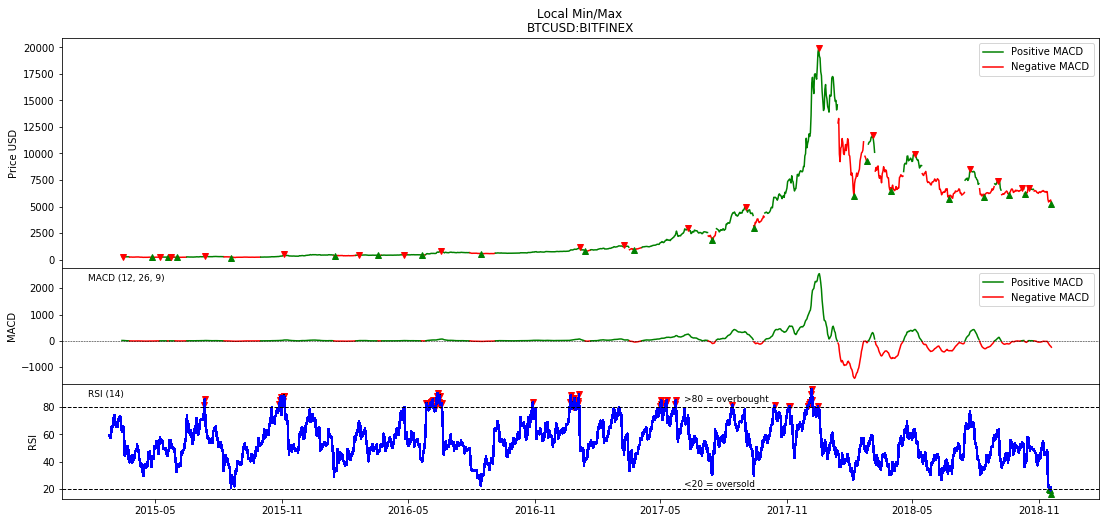

In [13]:
# Draw Line from price_local_minimum to price_local_maximum --> these are the waves that will be identified for further analysis and fractal geometry
# example from https://matplotlib.org/examples/pylab_examples/finance_work2.html
import matplotlib.patches as mpatches
fig = plt.figure(facecolor='white', figsize=(18,8))

axescolor = '#f6f6f6'  # the axes background color
textsize = 9
left, width = 0.1, 0.8
rect1 = [left, 0.6, width, 0.4]
rect2 = [left, 0.4, width, 0.2]
rect3 = [left, 0.2, width, 0.2]

ax1 = fig.add_axes(rect1)  # left, bottom, width, height
ax2 = fig.add_axes(rect2, sharex=ax1)
ax3 = fig.add_axes(rect3, sharex=ax2)

for wave in waves:
    if wave.macd[0] < 0:
        ax1.plot(wave.index,
                wave.low,
                'r-')
        index_min = min(range(len(wave.low)), key=wave.low.__getitem__)
        ax1.plot(wave.index[index_min],
             wave.low.min(),
            'g^')
         # Plot Macd 
        ax2.plot(wave.index, 
                 wave.macd,
                'r')
    
    if wave.macd[0] > 0:
        # Plot all high prices
        ax1.plot(wave.index,
                wave.high,
                'g-')
        
        # Plot local high
        index_max = max(range(len(wave.high)), key=wave.high.__getitem__)
        ax1.plot(wave.index[index_max],
                 wave.high.max(),
                'rv')
        # Plot Macd 
        ax2.plot(wave.index, 
                 wave.macd,
                'g')
    # Plot rsi
 
for i, strength in enumerate(rsi):
    if rsi[i] > overbought:
        ax3.plot(rsi.index[i], rsi[i],
                 'rv', linewidth=.2)
    elif rsi[i] < oversold:
        ax3.plot(rsi.index[i], rsi[i], 'g^', linewidth=.2)
    else:
        ax3.plot(rsi, 'b')
        
# Legend Config
red_patch = mpatches.mlines.Line2D([], [], color='red', label='Negative MACD')
green_patch = mpatches.mlines.Line2D([], [], color='green', label='Positive MACD')

# Ax1 config
ax1.set_title('Local Min/Max\nBTCUSD:%s' % (exchange))
ax1.set_ylabel('Price USD')
ax1.legend(handles=[green_patch, red_patch], loc='best')


# Ax2 labels
# ax2.set_title('MACD', pad=-10)
ax2.set_ylabel('MACD')
ax2.axhline(linewidth=.5, color='black', linestyle='--')
ax2.text(0.025, 0.95, 'MACD (%d, %d, %d)' % (slowperiod, fastperiod, signalperiod), va='top',
         transform=ax2.transAxes, fontsize=textsize)
ax2.legend(handles=[green_patch, red_patch], loc='best')

# Ax3 labels
# ax3.set_title('RSI', pad=-10)
ax3.set_ylabel('RSI')
ax3.axhline(y=80, linewidth=1, color='black', linestyle='--')
ax3.axhline(y=20, linewidth=1, color='black', linestyle='--')
ax3.text(0.025, 0.95, 'RSI (14)', va='top', transform=ax3.transAxes, fontsize=textsize)
ax3.text(0.6, 0.9, '>80 = overbought', va='top', transform=ax3.transAxes, fontsize=textsize)
ax3.text(0.6, 0.1, '<20 = oversold', transform=ax3.transAxes, fontsize=textsize)

plt.show()

# Find divergence

In [14]:
# We find the divergence by looking at the min price of one wave and comparing it with the min price of the next wave with a min and so on. If the macd
# is subsequently getting more positive while the price is getting lower then we have convergence.
# The opposite is try for max prices and max macd waves.
for i in range(len(waves_df)-2):
    # Bearish Divergence
    # Closest waves
    if (waves_df['MACD Max'][i] > waves_df['MACD Max'][i+2]) & (waves_df['Price Max'][i] < waves_df['Price Max'][i+2]):
        print('Bearish divergence between %s and %s' % (waves_df.Start[i], waves_df.End[i+2]))
 
    # Bullish Divergence
    if (waves_df['MACD Min'][i] < waves_df['MACD Min'][i+2]) & (waves_df['Price Min'][i] > waves_df['Price Min'][i+2]):
        print('Bullish divergence between %s and %s' % (waves_df.Start[i], waves_df.End[i+2]))
        
    # Look further to next waves
    if i+4 <= len(waves_df)-2:
           # Bearish Extended divergence
        if (waves_df['MACD Max'][i] > waves_df['MACD Max'][i+4]) & (waves_df['Price Max'][i] < waves_df['Price Max'][i+4]):
            print('Extended Bearish divergence between %s and %s' % (waves_df.Start[i], waves_df.End[i+4]))
            # Extended Bullish divergence
        if (waves_df['MACD Min'][i] < waves_df['MACD Min'][i+4]) & (waves_df['Price Min'][i] > waves_df['Price Min'][i+4]):
            print('Extended Bullish divergence between %s and %s' % (waves_df.Start[i], waves_df.End[i+4]))


Extended Bearish divergence between 2015-06-15 20:00:00 and 2016-03-17 20:00:00
Bearish divergence between 2016-02-15 19:00:00 and 2016-05-19 20:00:00
Bearish divergence between 2016-09-04 20:00:00 and 2017-03-16 20:00:00
Bullish divergence between 2018-03-08 19:00:00 and 2018-07-15 20:00:00
Extended Bullish divergence between 2018-03-08 19:00:00 and 2018-08-27 20:00:00
Bearish divergence between 2018-10-06 20:00:00 and 2018-10-23 20:00:00


In [15]:
# Change values of y_target to 1 and -1 to represent if the price increased or decreased from the previous data point.
# So on a daily chart if yesterday the candle closed at 6000 and today it closed at 7000 the 7000 would show a 1 for increase.

In [16]:
def rsi_extreme(row):
    if (row < overbought) & (row > oversold):
        return 0
    if (row < oversold):
        return -1
    if (row > overbought):
        return 1
    
df['rsi_extreme'] = df.rsi.apply(lambda row: rsi_extreme(row))

In [192]:
def divergence(waves_df):
    div = [0,0]
    for i in range(len(waves_df)-2):
        if (waves_df['MACD Max'][i] > waves_df['MACD Max'][i+2]) & (waves_df['Price Max'][i] < waves_df['Price Max'][i+2]):
             div.append(-1)
#             print('Bearish divergence between %s and %s' % (waves_df.Start[i], waves_df.End[i+2]))
        # Bullish Divergence
        elif (waves_df['MACD Min'][i] < waves_df['MACD Min'][i+2]) & (waves_df['Price Min'][i] > waves_df['Price Min'][i+2]):
            div.append(1)
        else:
            div.append(0)
    return div
#             print('Bullish divergence between %s and %s' % (waves_df.Start[i], waves_df.End[i+2]))

In [193]:
# Make column with diverging waves in waves_df
waves_df['divergence'] = divergence(waves_df)
# Make column in df fill with zeroes
df['Divergence'] = np.zeros(len(df))

# Fill waves with divergent values
# TODO: Must make this automatic and more elegant in automated program. For historical data this will work.
for i in waves_df[waves_df.divergence != 0].values:
    df.Divergence[i[0]:i[1]] = i[6]
    

# Building the DL network
Now that we have some key features including our wave profiler with divergence indicator and rsi extreme we can test out these values on a DL model.

In [196]:
# from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
# Clean up the data real quick
df.fillna(0, inplace=True)

columns = df.columns
scaler = MinMaxScaler()
# normalization
for c in columns[4:8]:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))

In [197]:
df.head()

,close,high,low,open,volumefrom,volumeto,macd,rsi,rsi_extreme,Divergence
timestamp,,,,,,,,,,
2015-02-08 19:00:00,220.61,225.00,215.40,224.22,0.111051,0.002921,0.35808,0.0,0.0,0.0
2015-02-09 19:00:00,220.96,223.88,214.00,220.61,0.109717,0.002880,0.35808,0.0,0.0,0.0
2015-02-10 19:00:00,219.19,224.40,218.10,220.96,0.072307,0.001920,0.35808,0.0,0.0,0.0
2015-02-11 19:00:00,222.60,223.20,217.87,219.19,0.041949,0.001111,0.35808,0.0,0.0,0.0
2015-02-12 19:00:00,236.00,241.76,221.46,222.39,0.109005,0.003062,0.35808,0.0,0.0,0.0


## Vectorizing our features for input

In [198]:
# Before we vecorize anything well need to split our dataset so we have a training and test set.
inputs = df.drop(['close','open','high','low'], axis=1)
outputs = df.close

#split training validation
training_size = int(0.8* df.shape[0])
x_train = inputs[:training_size]
x_test = outputs[:training_size]
# x_train_val = 
y_train = inputs[training_size:]
y_test = outputs[training_size:]

In [199]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    return model


model = build_model()
history = model.fit(x_train,
                    x_test,
                    epochs=5,
                    batch_size=1,
                    verbose=0)


In [200]:
mae_absolute_error = history.history['mean_absolute_error']
val_mse, val_mae = model.evaluate(y_train, y_test, verbose=0)

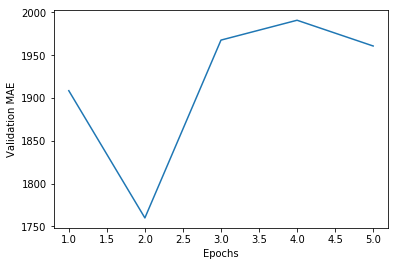

In [201]:
plt.plot(range(1, len(mae_absolute_error) +1), mae_absolute_error)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [202]:
predictions = model.predict(y_train)

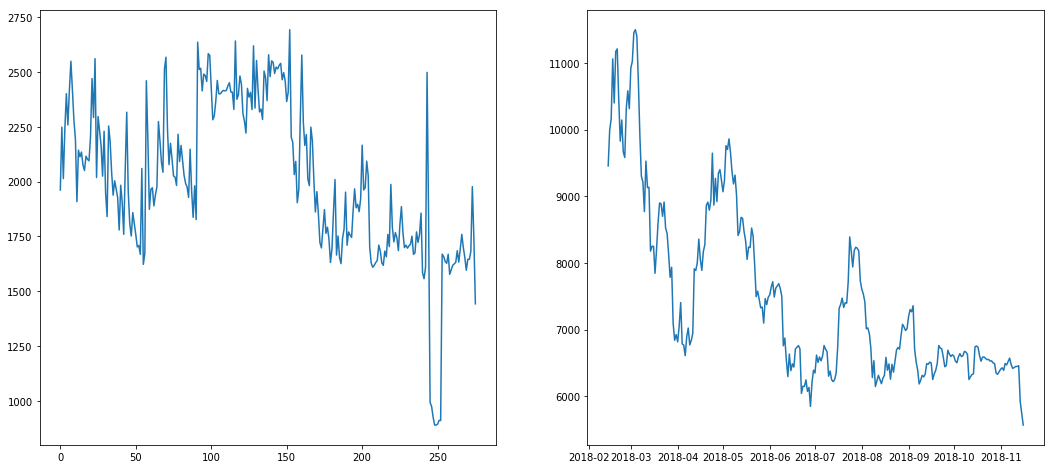

In [203]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8))
ax1.plot(predictions)
ax2.plot(y_test)

In [177]:
model.evaluate(y_train, y_test)

276/276 [==============================] - 0s 25us/step


[6408283.884057971, 2152.8392705502715]